### Installing Required Libraries

In [ ]:
!pip install opencv-python-headless
!pip install albumentations==0.4.6
!pip install kornia
!pip install opencv-python; sudo apt-get update; sudo apt-get install ffmpeg libsm6 libxext6  -y;

### Imports

In [2]:
import torch
import configs
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable  
from utils import WeatherDepthDataset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
from utils import load_checkpoint, save_checkpoint, save_some_examples, colorize, ssim, upscale_depth_tensor, upscale_depth_img, evaluate_model, DepthNorm, LogProgress

# Suppress warnings
np.seterr(divide='ignore', invalid='ignore')
torch.backends.cudnn.benchmark = True
%matplotlib inline


##### Test dataloaders

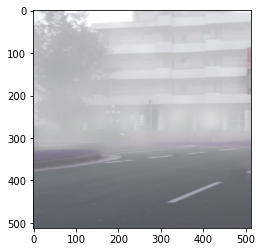

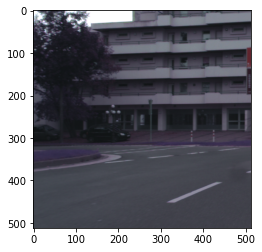

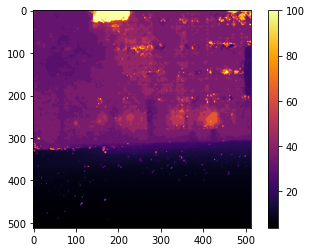

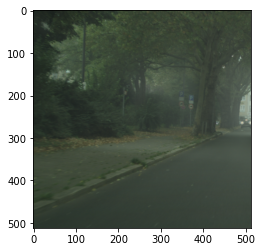

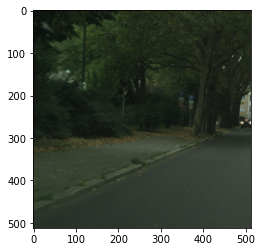

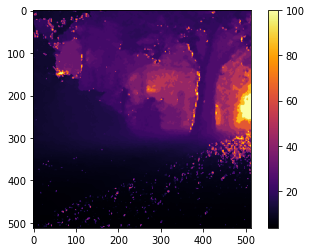

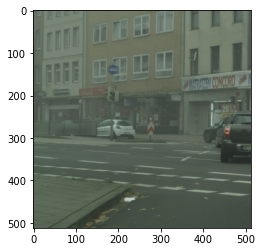

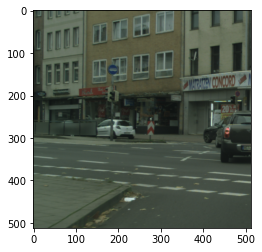

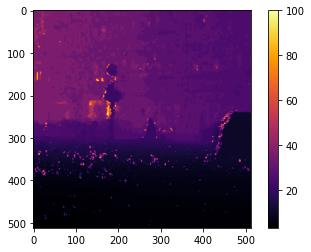

<Figure size 432x288 with 0 Axes>

In [3]:
dataset = WeatherDepthDataset(csv_file=configs.TRAIN_CSV ,root_dir=configs.ROOT_DIR, is_train=True)
loader = DataLoader(dataset, batch_size=1)

i = 0
for sample in loader:

  plt.imshow(torch.squeeze(sample['image']).permute(1, 2, 0))
  plt.figure()

  plt.imshow(torch.squeeze(sample['clear']).permute(1, 2, 0))
  plt.figure()

  plt.imshow(torch.squeeze(DepthNorm(sample['depth'])), cmap=configs.CMAP_STYLE)
  plt.colorbar()
  plt.figure()

  i += 1
  if (i > 2):
    break

### Depth Estimation Network

##### Encoder Network

In [ ]:
# Encoder uses the Densenet-169 pre-trained on Imagenet dataset
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()       
        self.original_model = models.densenet169( pretrained=True )

    def forward(self, x):
        features = [x]

        ''' Starting with the input image, the output received by feeding the last stored feature into each module of the Densenet 
        model is stored in features list '''
        
        for name, module in self.original_model.features._modules.items(): 
            features.append( module(features[-1]) )
        return features

##### Decoder Network

In [ ]:
'''
The decoder is composed of blocks of convolutional layers applied with 2x bilinear upsampling of the previous 
block connected with skip-connections to the block in the encoder with the same spatial size so each upsample 
block will have two inputs, one is the ouput of the previous block and second is from the skip-connections.
'''

class Decoder(nn.Module):
    def __init__(self, num_features=1664, decoder_width = 1.0):
        super(Decoder, self).__init__()

        # Defines the first conv2d layer to transform the output from encder depending on the size of the decoder / decoder_width
        features = int(num_features * decoder_width)
        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)
        
        # Defines the upsample blocks with input_features = output_features from previous layer + features from skip connection
        self.up1 = UpSample(input_features=features//1 + 256, output_features=features//2)
        self.up2 = UpSample(input_features=features//2 + 128,  output_features=features//4)
        self.up3 = UpSample(input_features=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(input_features=features//8 + 64,  output_features=features//16)

        # Defines final conv2d layer to transform the number of channels from 104 to 1 
        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        # Skip connections from encoder
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[3], features[4], features[6], features[8], features[12]
        # First conv2D layer transforms the output of the encoder based on the size of the decoder / decoder_width
        x_d0 = self.conv2(F.relu(x_block4))
        # First Upsample Block: concats output from encoder of shape (1664, 16, 16) with (256, 32, 32) block from encoder  ---> (832,32,32)
        x_d1 = self.up1(x_d0, x_block3)
        # Second Upsample Block: concats output of first upsample block with (128, 64, 64) block from encoder  ---> (416,64,64)
        x_d2 = self.up2(x_d1, x_block2)
        # Third Upsample Block: concats output of second upsample block with (64, 128, 128) block from encoder  ---> (208,128,128)
        x_d3 = self.up3(x_d2, x_block1)
        # Fourth Upsample Block: concats output of third upsample block with (64, 256, 256) block from encoder  ---> (104,256,256)
        x_d4 = self.up4(x_d3, x_block0)
        # Final conv2D layer transforms the output from fourth upsample layer into feature vector of shape (1,256,256)
        return self.conv3(x_d4)



# Upsample block with convolutional layers concatenated with 2x bilinear upsampling and skip connections
class UpSample(nn.Sequential):
    def __init__(self, input_features, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(input_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    # On each forward pass the input from skip connection is upscaled and concatenated with output from previous block
    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

##### Unet Generator Network

In [ ]:
# The Unet autoencoder formed by using the encoder and decoder is used as the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        out2 = self.encoder(x)
        out3 = self.decoder(out2)
        return out3

In [ ]:
# Testing generator model output

def test():
    x = torch.randn((1, 3, 512, 512))
    model = Generator()
    preds = model(x)
    print(preds.shape)

test()

# Cell Output -> torch.Size([1, 1, 256, 256])

##### Patch Discriminator Network

In [ ]:
'''
A Patch Discriminator is used so instead of returning a single probability of the input being a fake or not, 
it divides the image into patches and returns a matrix of probabilities of each patch being fake or not.
'''
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # In channels count is equal to the sum of channels in feature vector x and y 
        in_channels = 4

        ''' Defining the CNN blocks with conv2D layers with output channels(filters) of size 64, 128, 256, 512
        and a kernel size of 4 and stride of 2 except for the last block in order to form a patch size of 70x70 '''

        ''' All CNN blocks except for the first block will have a conv2D layer followed by a batch normalization 
        and a leaky relu layer '''
        self.block_0 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels=64, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2)
            )
        self.block_1 = CNNBlock(in_channels=64, out_channels=128, stride=2)
        self.block_2 = CNNBlock(in_channels=128, out_channels=256, stride=2)
        self.block_3 = CNNBlock(in_channels=256, out_channels= 512, stride=1)
        self.block_4 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1, padding_mode='reflect')


    def forward(self, x, y):
        # The predicted image x is concatenated with the ground-truth/ excepted image and passed into the discriminator blocks
        x = torch.cat([x, y], dim=1) #  Shape of x = (4, 512, 512)
        '''
        As mentioned in this thread "https://github.com/phillipi/pix2pix/issues/49#issuecomment-310819127" 
        The patch size of the discriminator can be calculated as follows:
            patch_size = (output_size - 1) * stride + kernel_size 
        '''
        x_0 = self.block_0(x)   #  Shape of x_0 = (64, 256, 256)    Patch_size = [(34-1) * 2 + 4] = 70
        x_1 = self.block_1(x_0) #  Shape of x_1 = (128, 128, 128)   Patch_size = [(16-1) * 2 + 4] = 34
        x_2 = self.block_2(x_1) #  Shape of x_2 = (256, 64, 64)     Patch_size = [(7-1) * 2 + 4] = 16
        x_3 = self.block_3(x_2) #  Shape of x_3 = (512, 63, 63)     Patch_size = [(4-1) * 1 + 4] = 7
        x_4 = self.block_4(x_3) #  Shape of x_4 = (1, 62, 62)       Patch_size = [(1-1) * 1 + 4] = 4
        return x_4



# Each CNN Block consists a conv2D followed by a BatchNorm and lealy relu layer
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
            )

    def forward(self, x):
        return self.conv(x)


In [ ]:
# Testing Patch Discriminator output

def test():
    x = torch.randn((1, 3, 512, 512))
    y = torch.randn((1, 1, 256, 256))
    model = Discriminator()
    preds = model(x, upscale_depth_tensor(y))
    print(preds.shape)

test()

# Cell Output -> torch.Size([1, 1, 62, 62])

### Initializing model, defining optimizer and other training parameters

In [ ]:
# Initializing models
disc = Discriminator().to(configs.DEVICE)
gen = Generator().to(configs.DEVICE)
print('Models created.')

# Defining optimizers
opt_disc = optim.Adam(disc.parameters(), lr=configs.LEARNING_RATE, betas=configs.BETAS)
opt_gen = optim.Adam(gen.parameters(), lr=configs.LEARNING_RATE)

# Defining training parameters
d_scaler = torch.cuda.amp.GradScaler()
g_scaler = torch.cuda.amp.GradScaler()

# Defining tensorboard logging parameters
prefix = 'WeatherDepth_' + str(configs.BATCH_SIZE)
writer = SummaryWriter(comment='{}-lr{}-e{}-bs{}'.format(prefix, configs.LEARNING_RATE, configs.NUM_EPOCHS, configs.BATCH_SIZE), flush_secs=30)


### Defining Loss Functions

##### Base Loss Functions

In [ ]:
# Binary cross entropy loss is used calculate how likely each image patch is real or fake.
# BCEWithLogitsLoss because it combines BCEloss with a sigmoid layer for better stability.
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

##### Generator Loss Function

In [ ]:
def generatorLoss(real_image, real_depth):
    # Fake depth map is generated by passing the real image to generator
    fake_depth = gen(real_image)

    '''
    1st Loss: The mean absolute error between fakedepth and the ground truth real depth  is calculated 
    and it is multiplied by l1_lamba of 100 to maximize the significance of this this loss over the other.'''
    G_L1 = L1_LOSS(upscale_depth_tensor(fake_depth), real_depth) * configs.L1_LAMBDA

    # The exact matrix of probabilites of real_image and fake_depth
    D_fake = disc(real_image, upscale_depth_tensor(fake_depth))

    '''
    2nd Loss: Adversarial Loss - The binary cross entropy loss of how likely D_Fake is 100% real is taken and 
    the generator is tricked into understanding the D_fake probability matrix as being real.
    '''
    G_fake_loss = BCE(D_fake, torch.ones_like(D_fake))

    ''' 
    3rd Loss: The structural similarity loss 
    '''
    structural_similarity = ssim(upscale_depth_tensor(fake_depth), real_depth)
    structural_similarity_clamped = torch.clamp((1 - structural_similarity) * 0.5, 0, 1).mean().item()
    SSIM_LOSS =  structural_similarity_clamped * configs.SSIM_LAMBDA
    G_loss = SSIM_LOSS + G_L1 + G_fake_loss
    return G_loss, D_fake

##### Patch Discriminator Loss Function

In [ ]:
def discriminatorLoss(real_image, real_depth):
    # Fake depth map is generated by passing the real image to generator
    fake_depth = gen(real_image)

    # The exact matrix of probabilites of real_image and real_depth
    D_real = disc(real_image, real_depth)
    # The exact matrix of probabilites of real_image and fake_depth
    D_fake = disc(real_image, upscale_depth_tensor(fake_depth.detach()))

    # Returns the likelihood the D_real is 100% real (Probability matix with all ones) 
    D_real_loss = BCE(D_real, torch.ones_like(D_real))
    # Returns the likelihood the D_fake is 100% fake (Probability matix with all zeros) 
    D_fake_loss = BCE(D_fake, torch.zeros_like(D_fake))

    # The final loss of the discriminator will be the average of D_real_loss and D_fake_loss
    D_loss = (D_real_loss + D_fake_loss) / 2
    return D_loss, D_real

### Initializing data loaders

In [ ]:
train_dataset = WeatherDepthDataset(csv_file=configs.TRAIN_CSV, root_dir=configs.ROOT_DIR, is_train=True)
train_loader = DataLoader(train_dataset, batch_size=configs.BATCH_SIZE, shuffle=True, num_workers=configs.NUM_WORKERS)

val_dataset = WeatherDepthDataset(csv_file=configs.VAL_CSV, root_dir=configs.ROOT_DIR)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

test_dataset = WeatherDepthDataset(csv_file=configs.TEST_CSV, root_dir=configs.ROOT_DIR)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Training the network

In [ ]:
# Load model if contueing from saved checkpoints
if configs.LOAD_MODEL:
    load_checkpoint(configs.CHECKPOINT_GEN, gen, opt_gen, configs.LEARNING_RATE, message='=> Loading generator checkpoint')
    load_checkpoint(configs.CHECKPOINT_DISC, disc, opt_disc, configs.LEARNING_RATE, message='=> Loading discriminator checkpoint')

# Start training...
for epoch in range(configs.NUM_EPOCHS + 1):

    loop = tqdm(train_loader, leave=True)
    N = len(train_loader)

    # Switching both models to train mode
    disc.train()
    gen.train()

    # Iterating through the traning dataset
    for idx, sample_batched in enumerate(loop):
        
        # RGB input image
        image = torch.autograd.Variable(sample_batched['image'].to(configs.DEVICE))
        # Ground truth disparity map
        depth = torch.autograd.Variable(sample_batched['depth'].to(configs.DEVICE))
        # Get the actual depth map from the ground truth disparity map
        depth_n = DepthNorm(depth)

        # Training the patch discriminator
        with torch.cuda.amp.autocast():
            D_loss, D_real = discriminatorLoss(image, depth_n)

        # Updating the discriminator model weights with combined discriminator loss
        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Training unet generator
        with torch.cuda.amp.autocast():
            G_loss, D_fake = generatorLoss(image, depth_n)

        # Updating the generator model weights with combined generator loss
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        n_iter = epoch*N+idx

        if idx % 10 == 0:
            # Log in results to tensorboard
            writer.add_scalar('Discriminator-Train/Loss', torch.sigmoid(D_real).mean().item(), n_iter)
            writer.add_scalar('Generator-Train/Loss', torch.sigmoid(D_fake).mean().item(), n_iter)

            # Displaying training results
            loop.set_postfix(
                Epoch = epoch,
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
                U_loss=G_loss.mean().item()
            )

        if idx % 300 == 0:
            LogProgress(gen, writer, test_loader, n_iter)

    # Record epoch's intermediate results
    LogProgress(gen, writer, test_loader, epoch)
    writer.add_scalar('Discriminator-Train/Loss', torch.sigmoid(D_real).mean().item(), epoch)
    writer.add_scalar('Generator-Train/Loss', torch.sigmoid(D_fake).mean().item(), epoch)
    
    # Save the trained model weights if required
    if configs.SAVE_MODEL:
      save_checkpoint(disc, opt_disc, filename=configs.CHECKPOINT_DISC, message='=> Saving discriminator checkpoint.')
      save_checkpoint(gen, opt_gen, filename=configs.CHECKPOINT_GEN, message='=> Saving generator checkpoint.')

    # Evaluating the model's performance after each epoch
    evaluate_model(gen, val_loader)
    # Saving some expamples to see the model's training progress
    save_some_examples(gen, test_loader, epoch)


### Testing the trained model

##### Load checkpoint if needed

In [ ]:
def load_checkpoint_state(checkpoint_file, model):
    print('=> Loading checkpoint state')
    checkpoint = torch.load(checkpoint_file, map_location=configs.DEVICE)
    model.load_state_dict(checkpoint['state_dict'])

model = Generator().to(configs.DEVICE)
load_checkpoint_state(configs.CHECKPOINT_GEN, model)
model.eval()

##### Generate depth maps from the test loader dataset

In [ ]:
for i,sample_test  in enumerate (test_loader):
    input_img = torch.autograd.Variable(sample_test['image'].cuda())

    pred_depth=gen(input_img) # predicted depth map tensor
    
    x=pred_depth.detach().cpu().numpy() # gets a numpy array from the tensor
    
    pred_resized = upscale_depth_img(x)
    plt.imsave('results/%d_depth.jpg' %i, pred_resized, cmap=configs.CMAP_STYLE) 
    
    s_img=input_img.detach().cpu().numpy().reshape(3,configs.IMAGE_SIZE,configs.IMAGE_SIZE).transpose(1,2,0)
    plt.imsave('results/%d_image.jpg' %i, s_img) 

    gt_resized = torch.squeeze(sample_test['depth'])
    gt_resized = DepthNorm(gt_resized)
    plt.imsave('results/%d_depth_gt.jpg' %i, gt_resized, cmap=configs.CMAP_STYLE) 

### Evaluating the trained model

##### Load checkpoint if needed

In [ ]:
def load_checkpoint_state(checkpoint_file, model):
    print('=> Loading checkpoint state')
    checkpoint = torch.load(checkpoint_file, map_location=configs.DEVICE)
    model.load_state_dict(checkpoint['state_dict'])

model = Generator().to(configs.DEVICE)
load_checkpoint_state(configs.CHECKPOINT_GEN, model)
model.eval()

##### Evaluate model

In [ ]:
evaluate_model(model, test_loader)

### Converting Pytorch model to CoreML model

In [ ]:

# Importing saved weights from checkpoint
def load_checkpoint_state(checkpoint_file, model):
    print('=> Loading checkpoint state')
    checkpoint = torch.load(checkpoint_file, map_location=configs.DEVICE)
    model.load_state_dict(checkpoint['state_dict'])

model = Generator().to(configs.DEVICE)
load_checkpoint_state(configs.CHECKPOINT_GEN, model)
# Moving model to eval state so weights will not be updated anymore
model.eval()
# Moving the model to cpu as the final Macos application will not have access to CUDA
model = model.to("cpu")
# Creating dummy input
dummy_input = torch.rand(1, 3, 512, 512)
# Tracing the model using the dummmy input
traced_model = torch.jit.trace(model, dummy_input)
# Creating the input image type
input_image = ct.ImageType(name="image", shape=(1, 3, 512, 512), scale=1.0/255.0)
# Converting the model
coreml_model = ct.convert(traced_model, inputs=[input_image])
# Renaming the output mutliarray type from spec
spec = coreml_model.get_spec()
ct.utils.rename_feature(spec, "var_2795", "depthmap")
# Updating the model from the updated spec
coreml_model = ct.models.MLModel(spec)
# Saving the CoreML model
coreml_model.save('coreML/AWDE_Model.mlmodel')